#Кейс "Золотая жила 2"

##Подключение библиотек и загрузка данных

In [ ]:
import pandas as pd, numpy as np, scipy.stats as sps, matplotlib.pyplot as plt
import statsmodels.stats.proportion as smp
from tqdm import tqdm






df = pd.read_csv('https://raw.githubusercontent.com/zalig/cu-datasets/main/golden_mine.csv')

# Очистка данных
df = df[(df['Profit']<1000000)&(df['Profit']>-1000000)]
for col in df.columns:
    try:
        df[col] = df[col].str.lower()
    except AttributeError:
        pass

##Функции

In [ ]:
def ztest_1sample(pop_mean, sample_mean, sample_std, sample_size, alternative='two-sided'):
    statistic = (sample_mean - pop_mean)/(sample_std / sample_size**0.5)
    if alternative == 'less':
        pvalue = sps.norm.cdf(statistic)
    if alternative == 'greater':
        pvalue = 1 - sps.norm.cdf(statistic)
    if alternative == 'two-sided':
        pvalue = 2 * (1 - sps.norm.cdf(abs(statistic)))
    return statistic, pvalue

def ztest_1sample_data(pop_mean, sample, alternative='two-sided'):
    return ztest_1sample(pop_mean, sample_mean=sample.mean(),
                         sample_std=sample.std(), sample_size=len(sample),
                         alternative=alternative)


def ztest_2sample(sample1_mean, sample2_mean, sample1_std, sample2_std, sample1_size, sample2_size, alternative='two-sided'):
    statistic = (sample1_mean - sample2_mean) / (sample1_std ** 2 / sample1_size + sample2_std ** 2 / sample2_size) ** 0.5
    if alternative == 'less':
        pvalue = sps.norm.cdf(statistic)
    if alternative == 'greater':
        pvalue = 1 - sps.norm.cdf(statistic)
    if alternative == 'two-sided':
        pvalue = 2 * (1 - sps.norm.cdf(abs(statistic)))
    return statistic, pvalue

def ztest_2sample_data(sample1, sample2, alternative='two-sided'):
    return ztest_2sample(
        sample1_mean=sample1.mean(), sample2_mean=sample2.mean(),
        sample1_std=sample1.std(), sample2_std=sample2.std(),
        sample1_size=len(sample1), sample2_size=len(sample2),
        alternative=alternative
    )


def zpower_1sample_data_monte_carlo(mu0, mu, sigma, sample_size, n_monte_carlo, significance_level=0.05):
    rejections = 0

    for _ in range(n_monte_carlo):
        sample = sps.norm.rvs(loc=mu, scale=sigma, size=sample_size)
        test_stat, pvalue = ztest_1sample(pop_mean=mu0, sample_mean=sample.mean(),
                                          sample_std=sample.std(), sample_size=len(sample), alternative='greater')
        if pvalue < significance_level:
            rejections += 1

    return rejections / n_monte_carlo

##Слайды

###Синий уровень

In [ ]:
#тест прибыльности привлечения клиента без таргетирования

ztest_1sample_data(pop_mean=0, sample=df['Profit'] - 15_000, alternative='greater')



(3.5021147923588165, 0.00023079035103212853)

In [ ]:
#тест различия средней прибыли в категориях мужчин 18-24 и женщины 18-24

man_1824 = df[(df['Gender'] == 'male') & (df['AgeGroup']=='18-24')]['Profit']
women_1824 = df[(df['Gender'] == 'female') & (df['AgeGroup']=='18-24')]['Profit']

ztest_2sample_data(sample1=man_1824, sample2=women_1824, alternative='two-sided')

(-27.09280730417151, 0.0)

In [ ]:
print(man_1824.mean(), women_1824.mean())

13155.762435444414 26278.37389380531


In [ ]:
#тест значимости прибыли для мужчин 18-24

ztest_1sample_data(pop_mean=0, sample=man_1824 - 15_000, alternative='greater')

(-4.065077065970156, 0.9999759917034207)

In [ ]:
#тест значимости прибыли для женщин 18-24

ztest_1sample_data(pop_mean=0, sample=women_1824 - 15_000, alternative='greater')

(66.48342590449387, 0.0)

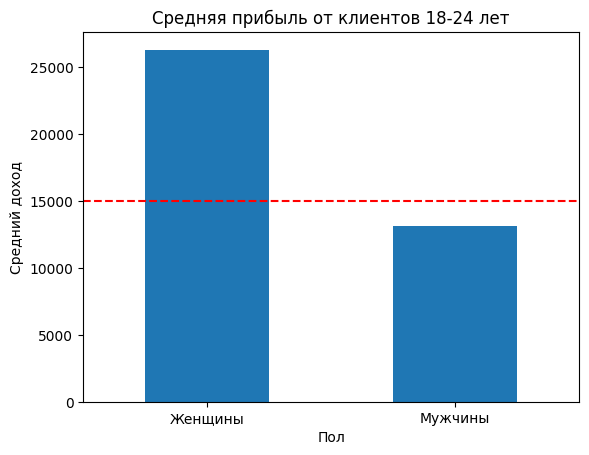

In [26]:
#построение графиков для синих слайдов
table_meanprof = df[df['AgeGroup'] == '18-24'].groupby(["Gender","AgeGroup"]).agg({'Profit':'mean'})

table_meanprof.plot(kind='bar',xlabel='Пол',ylabel='Средний доход',legend=False).set_xticklabels(['Женщины', 'Мужчины'], rotation=0)


plt.axhline(y=15000, color='r', linestyle='--', label='Стоимость привлечения клиентов')
plt.title('Средняя прибыль от клиентов 18-24 лет')
plt.show()

###Красный уровень

In [ ]:
#корректировка уровня значимости
0.05/3

In [23]:
women_18_21 = df[(df['Gender'] == 'female') & (df['Age']<=21)]['Profit']
women_22_24 = df[(df['Gender'] == 'female') & (df['Age']>=22) & ( df['Age']<=24)]['Profit']

print('Тест прибыльности среди женщин 18-21', ztest_1sample_data(pop_mean=0, sample=women_18_21 - 15000, alternative='greater'))
print('Тест прибыльности среди женщин 22-24', ztest_1sample_data(pop_mean=0, sample=women_22_24 - 15000, alternative='greater'))
print('Тест значимости разницы между этими категориями', ztest_1sample_data(pop_mean=0, sample=women_22_24 - 15000, alternative='greater'))

Тест прибыльности среди женщин 18-21 (59.570845699717985, 0.0)
Тест прибыльности среди женщин 22-24 (32.5007531203702, 0.0)
Тест значимости разницы между этими категориями (32.5007531203702, 0.0)


In [ ]:
print(df[(df['Gender'] == 'female') & (df['Age']>=22)]['Profit'].mean())

12392.662219526987


<ipython-input-51-07e79c6a179c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['AgeGroup'] = df_1['Age'].apply(lambda x: categorize_age(x))


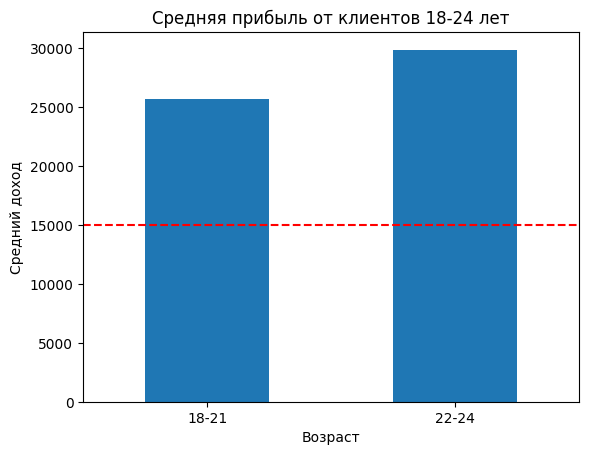

,Profit
AgeGroup,
18-21,25716.510439
22-24,29891.232877


In [51]:
def categorize_age(age):
  if 18<=age<=21:
    return '18-21'
  elif 22<=age<=24:
    return '22-24'
  elif 25<=age<=40:
    return '25-39'
  elif 40<=age:
    return '40+'



df_1 = df[df['Gender'] == 'female']

df_1['AgeGroup'] = df_1['Age'].apply(lambda x: categorize_age(x))


table_meanprof = df_1[(df_1['AgeGroup'] == '18-21')|(df_1['AgeGroup'] == '22-24')].groupby(["AgeGroup"]).agg({'Profit':'mean'})

table_meanprof.plot(kind='bar',xlabel='Возраст',ylabel='Средний доход',legend=False)

plt.xticks(rotation=0)
plt.axhline(y=15000, color='r', linestyle='--', label='Стоимость привлечения клиентов')
plt.title('Средняя прибыль от клиентов 18-24 лет')
plt.show()

table_meanprof

###Черный уровень

In [ ]:
#золотая жила из кейса 1
golden_mine = df[(df['Gender'] == 'male') & (df['Age'].isin([21, 22, 23, 24]))]['Profit']

women_18_24 = df[(df['Gender'] == 'female') & (df['AgeGroup']=='18-24')]['Profit']

ztest_2sample_data(sample1=golden_mine, sample2=women_18_24, alternative='two-sided')

(104.86410083908079, 0.0)

In [ ]:
man_18 =  df[(df['Gender'] == 'male') & (df['Age']==18)]['Profit']

for effect in np.arange(0, 1000, 5):
  if zpower_1sample_data_monte_carlo(mu0=15000, mu=15000 + effect, sigma=man_18.std(), sample_size=len(man_18), n_monte_carlo=1000, significance_level=0.05) >= 0.8:
    print('Минимально детектируемый эффект:', effect)
    break

Минимально детектируемый эффект: 145


In [24]:
#корректировка уровня значимости
0.05/7

0.0071428571428571435

In [25]:
man_18 =  df[(df['Gender'] == 'male') & (df['Age']==18)]['Profit']
man_19 =  df[(df['Gender'] == 'male') & (df['Age']==19)]['Profit']
man_20 =  df[(df['Gender'] == 'male') & (df['Age']==20)]['Profit']
man_21 =  df[(df['Gender'] == 'male') & (df['Age']==21)]['Profit']
man_22 =  df[(df['Gender'] == 'male') & (df['Age']==22)]['Profit']
man_23 =  df[(df['Gender'] == 'male') & (df['Age']==23)]['Profit']
man_24 =  df[(df['Gender'] == 'male') & (df['Age']==24)]['Profit']


for effect in np.arange(0, 1000, 5):
    if zpower_1sample_data_monte_carlo(mu0=15000, mu=15000 + effect, sigma=man_18.std(), sample_size=len(man_18), n_monte_carlo=1000, significance_level=0.05/7) >= 0.8 \
    or zpower_1sample_data_monte_carlo(mu0=15000, mu=15000 + effect, sigma=man_19.std(), sample_size=len(man_19), n_monte_carlo=1000, significance_level=0.05/7) >= 0.8 \
    or zpower_1sample_data_monte_carlo(mu0=15000, mu=15000 + effect, sigma=man_20.std(), sample_size=len(man_20), n_monte_carlo=1000, significance_level=0.05/7) >= 0.8 \
    or zpower_1sample_data_monte_carlo(mu0=15000, mu=15000 + effect, sigma=man_21.std(), sample_size=len(man_21), n_monte_carlo=1000, significance_level=0.05/7) >= 0.8 \
    or zpower_1sample_data_monte_carlo(mu0=15000, mu=15000 + effect, sigma=man_22.std(), sample_size=len(man_22), n_monte_carlo=1000, significance_level=0.05/7) >= 0.8 \
    or zpower_1sample_data_monte_carlo(mu0=15000, mu=15000 + effect, sigma=man_23.std(), sample_size=len(man_23), n_monte_carlo=1000, significance_level=0.05/7) >= 0.8 \
    or zpower_1sample_data_monte_carlo(mu0=15000, mu=15000 + effect, sigma=man_24.std(), sample_size=len(man_24), n_monte_carlo=1000, significance_level=0.05/7) >= 0.8 :
        print('Минимально детектируемый эффект:', effect)
        break

Минимально детектируемый эффект: 195


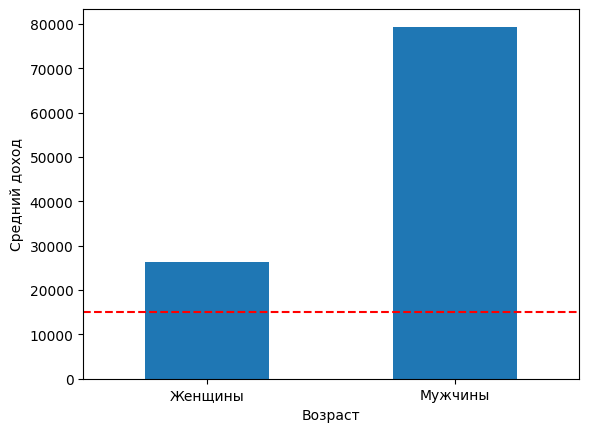

In [52]:
def categorize_age(age):
  if 18<=age<=21:
    return '18-21'
  elif 22<=age<=24:
    return '22-24'
  elif 25<=age<=40:
    return '25-39'
  elif 40<=age:
    return '40+'



df_2 = df[(df['AgeGroup'] == '18-24')]

df_2 = df_2[(df_2['Gender'] == 'female')|((df_2['Gender'] == 'male')&(df_2['Age'].isin([21,22,23,24])))]


table_meanprof = df_2.groupby(["AgeGroup", 'Gender']).agg({'Profit':'mean'})

table_meanprof.plot(kind='bar',xlabel='Возраст',ylabel='Средний доход',legend=False).set_xticklabels(['Женщины', 'Мужчины'], rotation=0)
plt.axhline(y=15000, color='r', linestyle='--', label='Стоимость привлечения клиентов')
plt.show()